# -Importing needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn import datasets
import warnings

warnings.filterwarnings("ignore")

# -generating the 4 datasets

In [2]:
# Given attributes for the predictive maintenance dataset
n_samples = 300
random_state = 1000

# Generate Dataset1: blobs dataset representing normal operation, minor fault, and major fault conditions
X1, y1 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=random_state)


# Generate Dataset2: Anisotropically distributed dataset to simulate different operating conditions
X2, y2 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X2 = np.dot(X2, transformation)

# Generate Dataset3: noisy moons dataset to represent cyclic patterns in equipment behavior
X3, y3 = datasets.make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)

# Generate Dataset4: noisy circles dataset to represent more complex cyclic patterns possibly in larger equipment
X4, y4 = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05, random_state=random_state)

# -Plotting the Datasets Generated

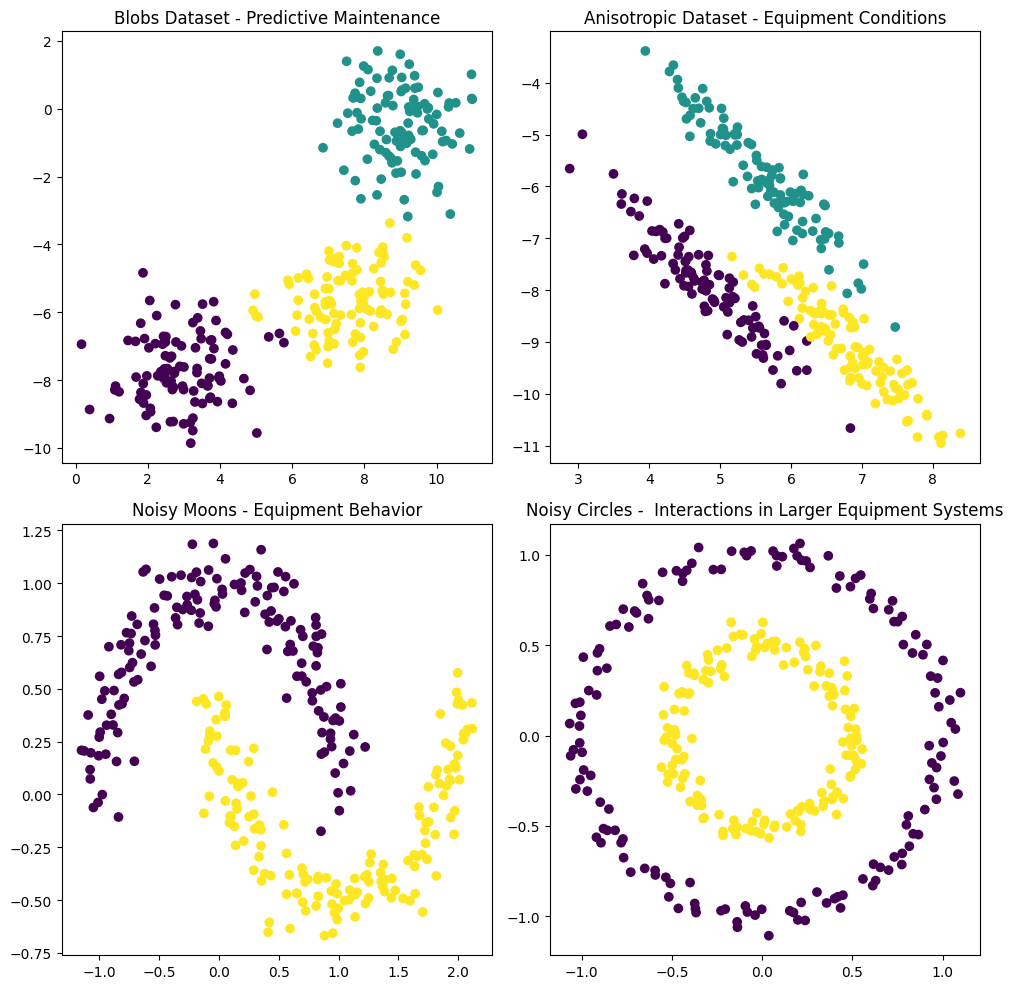

In [3]:
# Plotting the datasets including the new noisy circles dataset
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot Dataset1: Blobs Dataset
axes[0, 0].scatter(X1[:, 0], X1[:, 1], c=y1)
axes[0, 0].set_title('Blobs Dataset - Predictive Maintenance')

# Plot Dataset2: Anisotropically Distributed Dataset
axes[0, 1].scatter(X2[:, 0], X2[:, 1],c=y2)
axes[0, 1].set_title('Anisotropic Dataset - Equipment Conditions')

# Plot Dataset3: Noisy Moons Dataset
axes[1, 0].scatter(X3[:, 0], X3[:, 1], c=y3)
axes[1, 0].set_title('Noisy Moons - Equipment Behavior')

# Plot Dataset4: Noisy Circles Dataset
axes[1, 1].scatter(X4[:, 0], X4[:, 1], c=y4)
axes[1, 1].set_title('Noisy Circles -  Interactions in Larger Equipment Systems')

plt.tight_layout()
plt.show()

# -Identifing K-mean and DBSCAN

In [4]:
# K-Means Algorithm Implementation
def k_means(X, n_clusters, max_iters=100):
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels

# DBSCAN Algorithm Implementation

def dbscan(X, eps, min_samples):
    labels = np.full(X.shape[0], -1)
    cluster_id = 0
    
    for idx in range(X.shape[0]):
        if labels[idx] != -1:
            continue  # Already labeled
        # Find neighbors within eps
        neighbors = np.linalg.norm(X - X[idx], axis=1) < eps
        if np.sum(neighbors) < min_samples:
            labels[idx] = -2  # Mark as noise
            continue
        # Found a core point
        labels[idx] = cluster_id
        # Create a list of points to be analyzed, starting with the current point's neighbors
        search_queue = np.where(neighbors)[0].tolist()
        for neighbor_idx in search_queue:
            if labels[neighbor_idx] == -2:
                labels[neighbor_idx] = cluster_id  # Change noise to border point
            if labels[neighbor_idx] != -1:
                continue  # Already labeled
            labels[neighbor_idx] = cluster_id
            # Check for neighbors of this point
            expanded_neighbors = np.linalg.norm(X - X[neighbor_idx], axis=1) < eps
            if np.sum(expanded_neighbors) >= min_samples:
                # Add the new neighbors to the queue
                search_queue.extend(np.where(expanded_neighbors)[0])
        cluster_id += 1
    return labels

# -Identifing Elbow Method and K-Distance

In [5]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

#  Function for the Elbow Method

def elbow_method(X, k_range, axis):
    sum_of_squared_distances = []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10)
        km = km.fit(X)
        sum_of_squared_distances.append(km.inertia_)
    
    axis.plot(k_range, sum_of_squared_distances, 'bx-')
    axis.set_xlabel('k')
    axis.set_ylabel('Sum of squared distances')
    axis.set_title('Elbow Method For Optimal k')

#  Function for K-Distance Graph
def k_distance_graph(X, k, axis):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)

    sorted_distances = np.sort(distances[:, k-1], axis=0)
    axis.plot(list(range(1, len(sorted_distances)+1)), sorted_distances)
    axis.set_xlabel('Points')
    axis.set_ylabel(f'Distance to {k}-th nearest neighbor')
    axis.set_title('K-Distance Graph')


# -Apply Elbow Method and K-Distance Graph for each Dataset


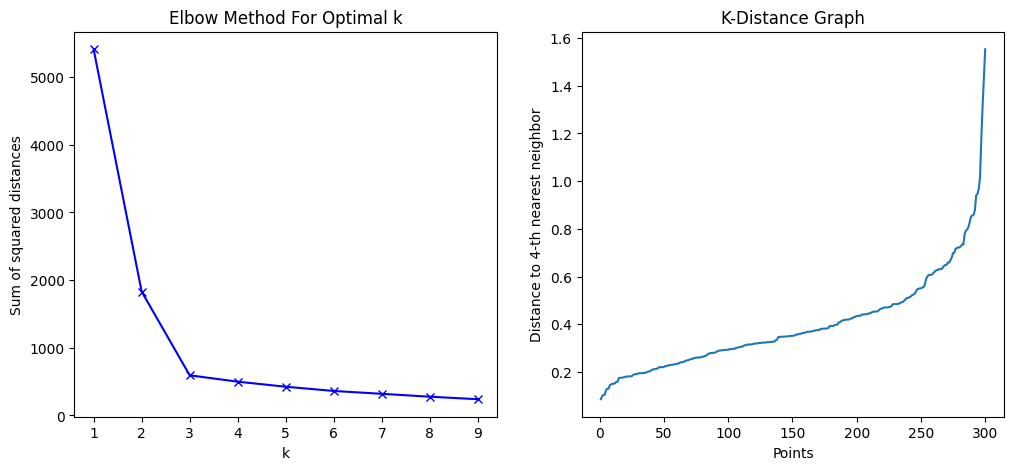

In [6]:
# Dataset 1
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
elbow_method(X1, range(1, 10), axes[0])
k_distance_graph(X1, 4, axes[1])

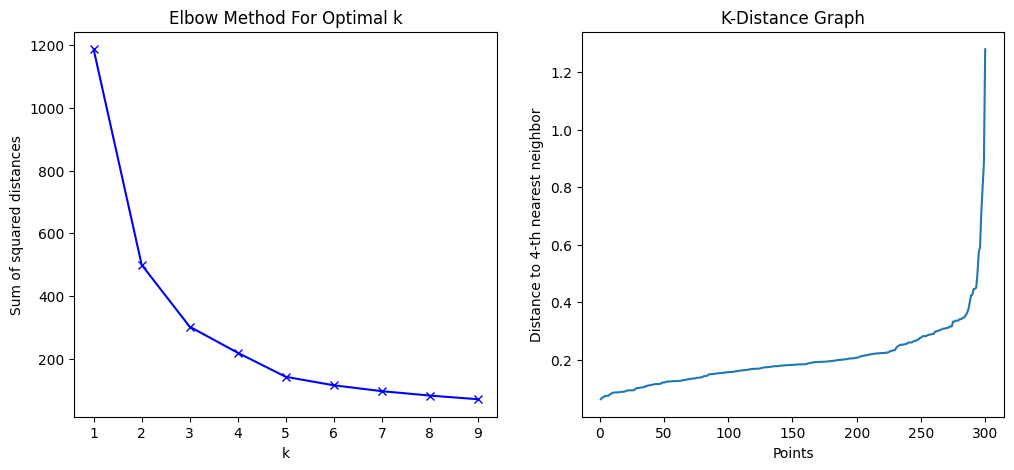

In [7]:
# Dataset 2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
elbow_method(X2, range(1, 10), axes[0])
k_distance_graph(X2, 4, axes[1])

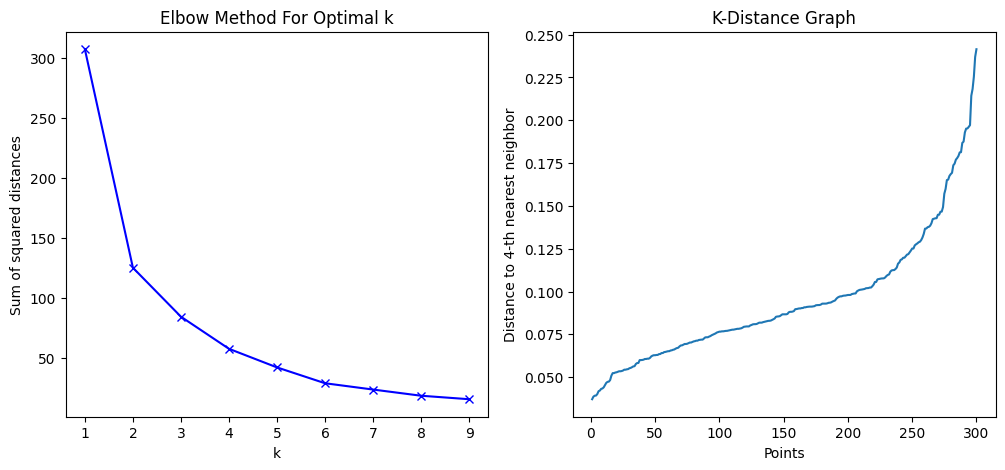

In [8]:
# Dataset 3
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
elbow_method(X3, range(1, 10), axes[0])
k_distance_graph(X3, 4, axes[1])

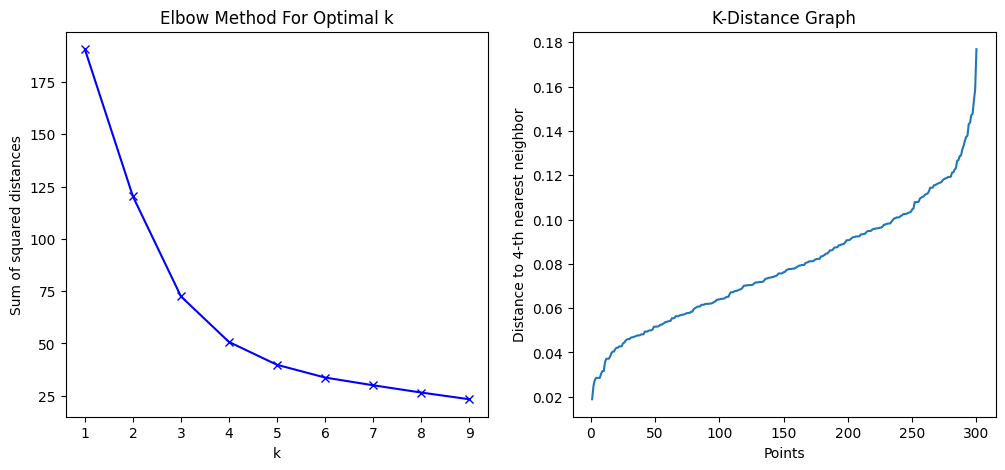

In [9]:
# Dataset 4
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
elbow_method(X4, range(1, 10), axes[0])
k_distance_graph(X4, 4, axes[1])

# -Generating, Applying, Plotting 

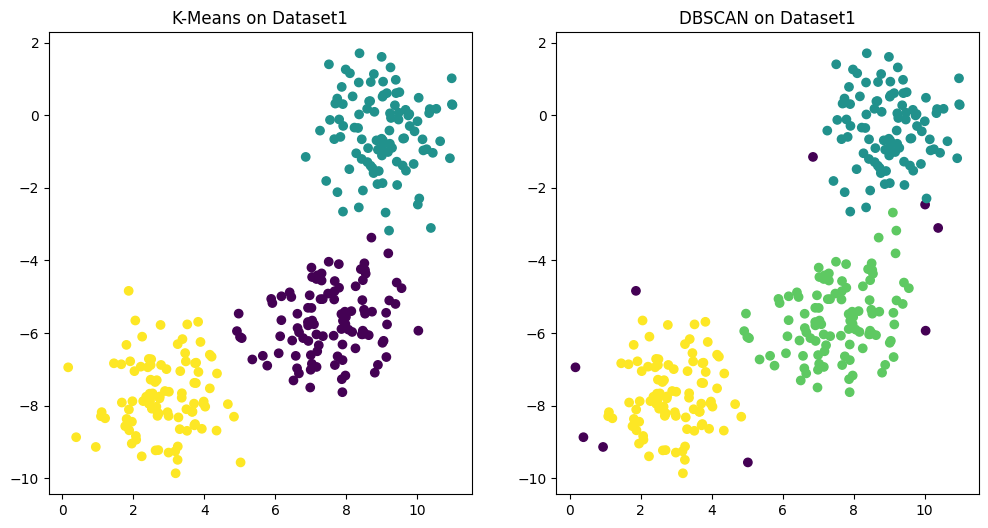

In [10]:
# Apply K-Means and DBSCAN to Dataset1
kmeans_labels_1 = k_means(X1, n_clusters=3)
dbscan_labels_1 = dbscan(X1, eps=0.75, min_samples=4)

# Plotting results for Dataset1
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X1[:, 0], X1[:, 1], c=kmeans_labels_1)
plt.title("K-Means on Dataset1")

plt.subplot(1, 2, 2)
plt.scatter(X1[:, 0], X1[:, 1], c=dbscan_labels_1)
plt.title("DBSCAN on Dataset1")

plt.show()


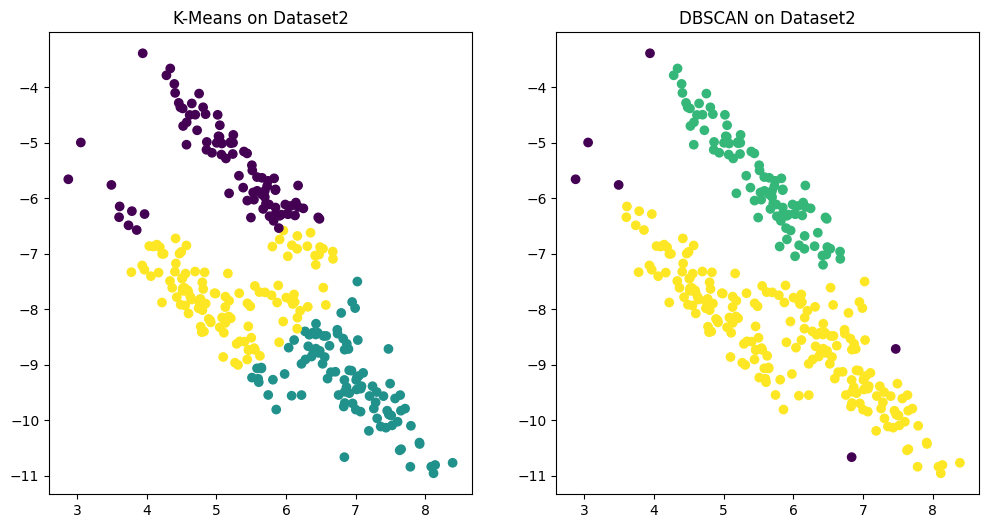

In [11]:
# Apply K-Means and DBSCAN to Dataset2
kmeans_labels_2 = k_means(X2, n_clusters=3)
dbscan_labels_2 = dbscan(X2, eps=0.4, min_samples=4)

# Plotting results for Dataset2
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X2[:, 0], X2[:, 1], c=kmeans_labels_2)
plt.title("K-Means on Dataset2")

plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=dbscan_labels_2)
plt.title("DBSCAN on Dataset2")

plt.show()


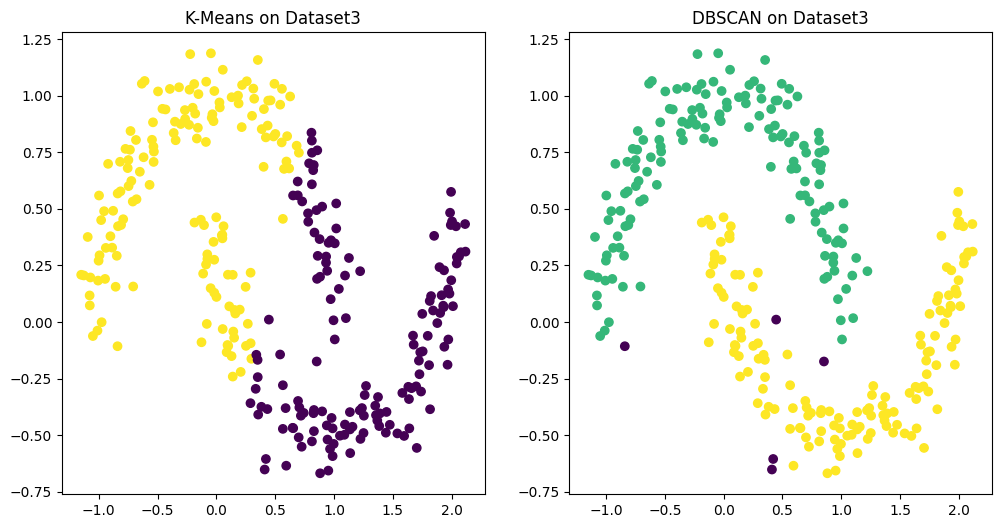

In [12]:
# Apply K-Means and DBSCAN to Dataset3
kmeans_labels_3 = k_means(X3, n_clusters=2)
dbscan_labels_3 = dbscan(X3, eps=0.17, min_samples=4)

# Plotting results for Dataset3
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X3[:, 0], X3[:, 1], c=kmeans_labels_3)
plt.title("K-Means on Dataset3")

plt.subplot(1, 2, 2)
plt.scatter(X3[:, 0], X3[:, 1], c=dbscan_labels_3)
plt.title("DBSCAN on Dataset3")

plt.show()



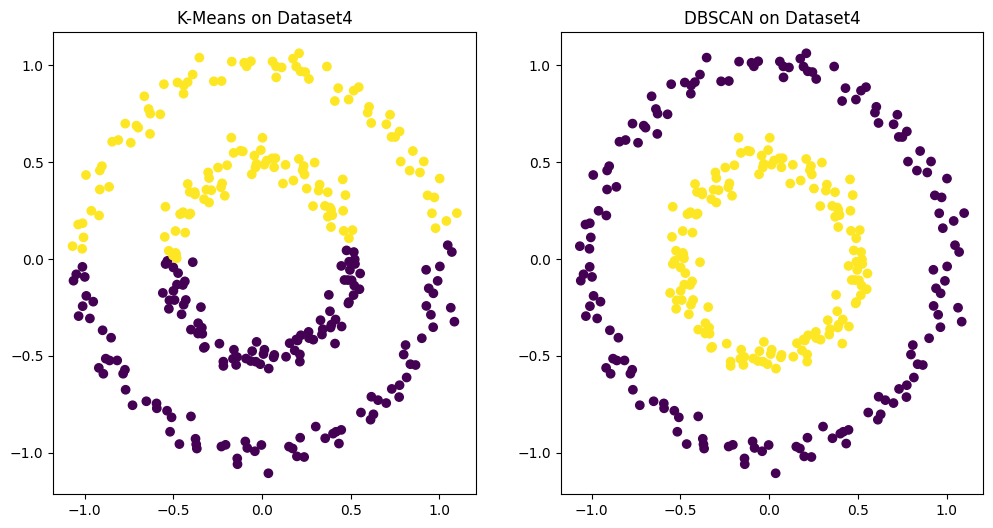

In [13]:
# Apply K-Means and DBSCAN to Dataset4
kmeans_labels_4 = k_means(X4, n_clusters=2)
dbscan_labels_4 = dbscan(X4, eps=0.16, min_samples=5)

# Plotting results for Dataset4
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X4[:, 0], X4[:, 1], c=kmeans_labels_4)
plt.title("K-Means on Dataset4")

plt.subplot(1, 2, 2)
plt.scatter(X4[:, 0], X4[:, 1], c=dbscan_labels_4)
plt.title("DBSCAN on Dataset4")

plt.show()


# -Evaluating

In [18]:
from sklearn.metrics import f1_score, normalized_mutual_info_score, adjusted_rand_score

# Function to calculate the evaluation metrics
def calculate_metrics(true_labels, predicted_labels):
    metrics = {
        'F-measure': f1_score(true_labels, predicted_labels, average='weighted'),
        'NMI': normalized_mutual_info_score(true_labels, predicted_labels),
        'Rand Statistic': adjusted_rand_score(true_labels, predicted_labels)
    }
    return metrics

# Calculate metrics for each dataset and algorithm
metrics_results = {
    'Dataset1': {
        'K-Means': calculate_metrics(y1, kmeans_labels_1),
        'DBSCAN': calculate_metrics(y1, dbscan_labels_1)
    },
    'Dataset2': {
        'K-Means': calculate_metrics(y2, kmeans_labels_2),
        'DBSCAN': calculate_metrics(y2, dbscan_labels_2)
    },
    'Dataset3': {
        'K-Means': calculate_metrics(y3, kmeans_labels_3),
        'DBSCAN': calculate_metrics(y3, dbscan_labels_3)
    },
    'Dataset4': {
        'K-Means': calculate_metrics(y4, kmeans_labels_4),
        'DBSCAN': calculate_metrics(y4, dbscan_labels_4)
    }
}


for dataset in metrics_results:
    print(f"Metrics for {dataset}:")
    for algorithm, metrics in metrics_results[dataset].items():
        formatted_metrics = {metric: f"{value:.3f}" for metric, value in metrics.items()}
        print(f"  {algorithm} Metrics: {formatted_metrics}")
    print("\n")


Metrics for Dataset1:
  K-Means Metrics: {'F-measure': '0.343', 'NMI': '0.959', 'Rand Statistic': '0.970'}
  DBSCAN Metrics: {'F-measure': '0.007', 'NMI': '0.864', 'Rand Statistic': '0.905'}


Metrics for Dataset2:
  K-Means Metrics: {'F-measure': '0.114', 'NMI': '0.429', 'Rand Statistic': '0.447'}
  DBSCAN Metrics: {'F-measure': '0.011', 'NMI': '0.614', 'Rand Statistic': '0.496'}


Metrics for Dataset3:
  K-Means Metrics: {'F-measure': '0.260', 'NMI': '0.173', 'Rand Statistic': '0.228'}
  DBSCAN Metrics: {'F-measure': '0.992', 'NMI': '0.934', 'Rand Statistic': '0.967'}


Metrics for Dataset4:
  K-Means Metrics: {'F-measure': '0.493', 'NMI': '0.000', 'Rand Statistic': '-0.003'}
  DBSCAN Metrics: {'F-measure': '1.000', 'NMI': '1.000', 'Rand Statistic': '1.000'}




# - Visualization and comparing

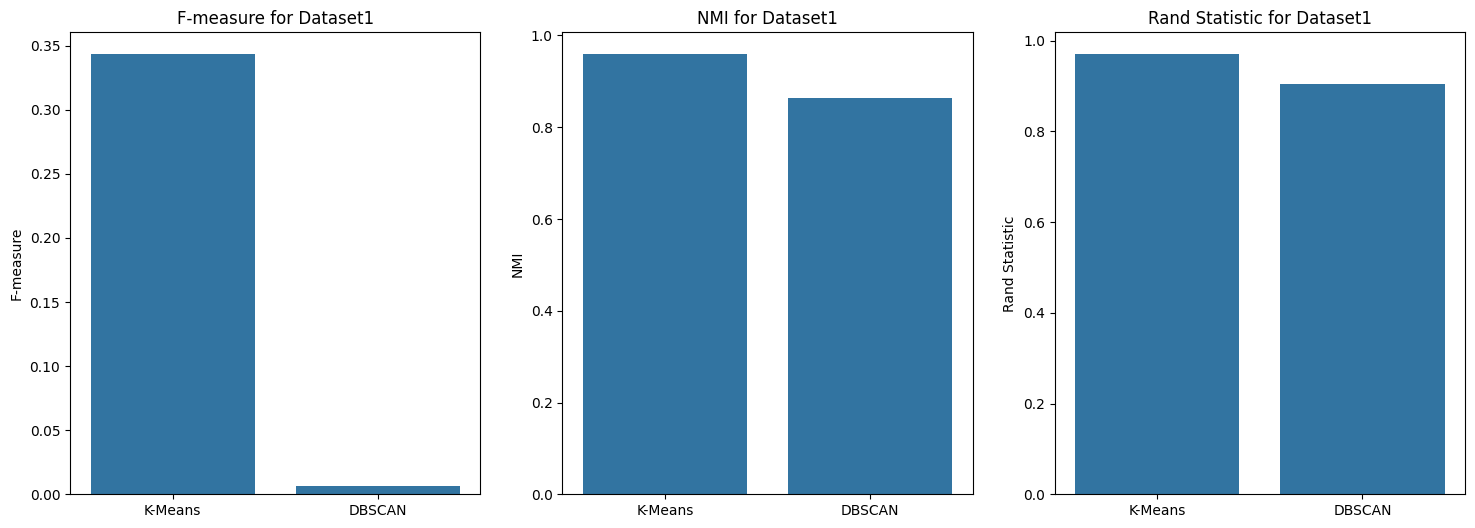

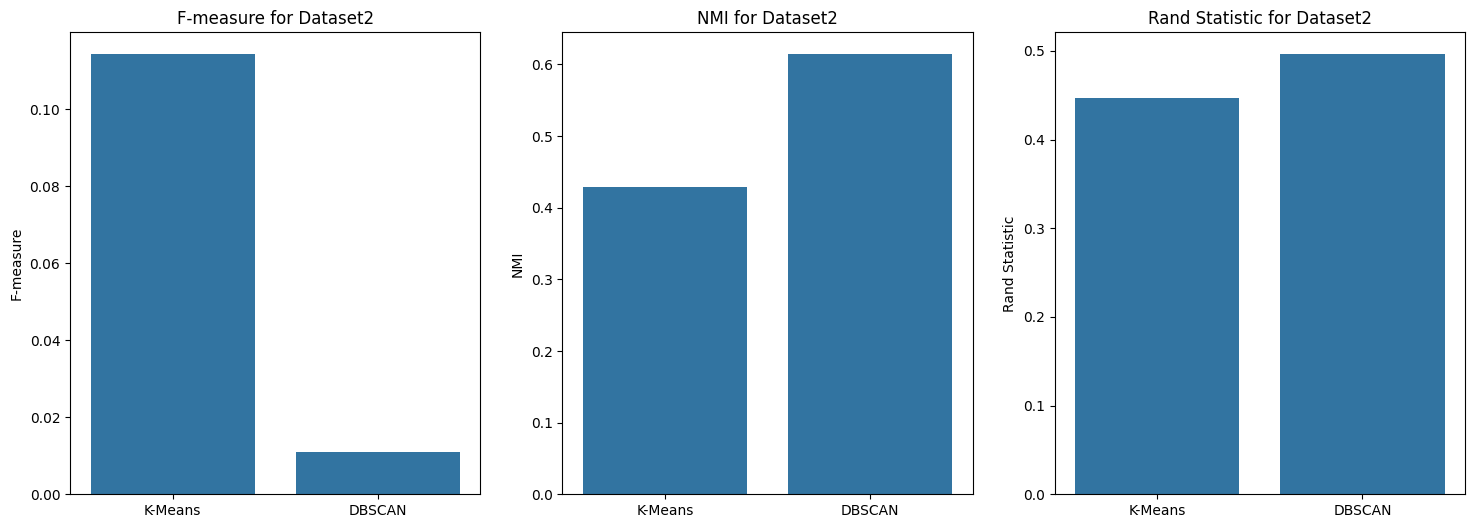

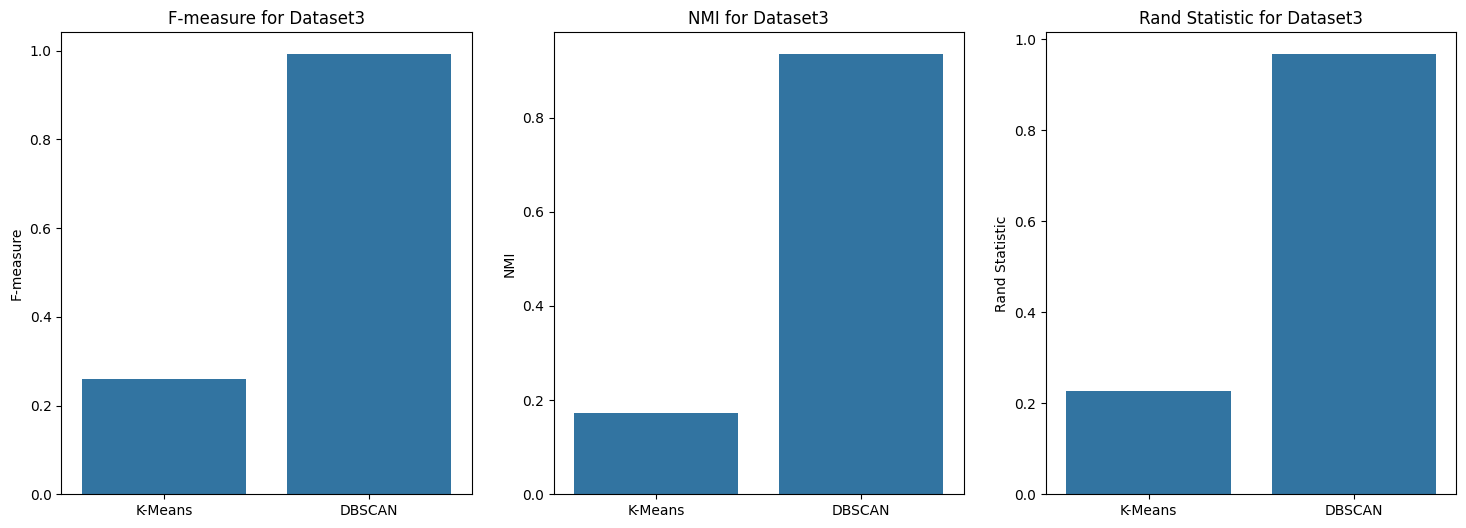

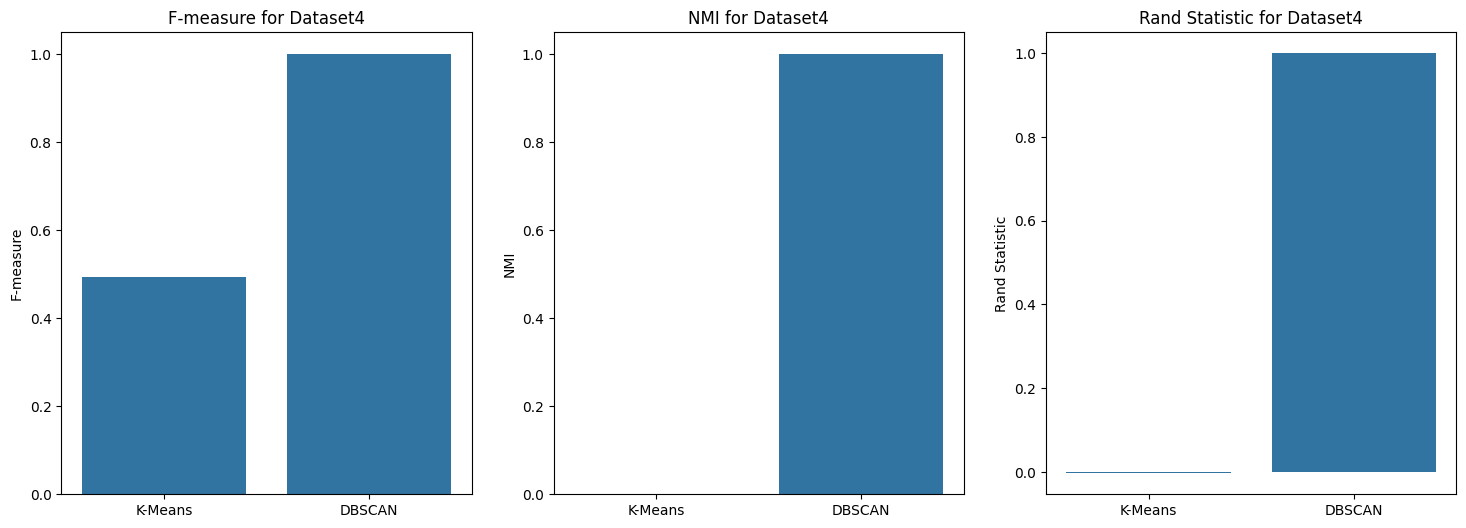

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


for dataset in metrics_results:
    plt.figure(figsize=(18, 6))  

    # F-measure Plot
    plt.subplot(1, 3, 1)  
    sns.barplot(x=list(metrics_results[dataset].keys()), y=[metrics['F-measure'] for metrics in metrics_results[dataset].values()])
    plt.title(f"F-measure for {dataset}")
    plt.ylabel('F-measure')

    # NMI Plot
    plt.subplot(1, 3, 2)  
    sns.barplot(x=list(metrics_results[dataset].keys()), y=[metrics['NMI'] for metrics in metrics_results[dataset].values()])
    plt.title(f"NMI for {dataset}")
    plt.ylabel('NMI')

    # Rand Statistic Plot
    plt.subplot(1, 3, 3)  
    sns.barplot(x=list(metrics_results[dataset].keys()), y=[metrics['Rand Statistic'] for metrics in metrics_results[dataset].values()])
    plt.title(f"Rand Statistic for {dataset}")
    plt.ylabel('Rand Statistic')

    plt.show()
